# Python Scripts for Chapter 2 

## Initialize 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import gzip
## Constants for this noteboook
figOutputPath = '../chapter2/pics/'
dataPath = './_Data/'

For ease of collabortion, the following code cell compresses the text data files. This code chunk should not be run again but is left for reference. -khris

In [ ]:
# Save the text file with compression
'''
import shutil

with open(dataPath+'singleages.txt', 'rb') as fIn:
    with gzip.open(dataPath+'singleages.txt.gz', 'wb') as fOut:
        shutil.copyfileobj(fIn,fOut)

with open(dataPath+'LYMYLEUK.TXT', 'rb') as fIn:
    with gzip.open(dataPath+'LYMYLEUK.txt.gz', 'wb') as fOut:
        shutil.copyfileobj(fIn,fOut)
'''
#not run

###  Population data for SEER dataset

In [2]:
# import population data at each year from 1973-2014
#dfSA=pd.read_csv(dataPath+'singleages.txt', sep='\t', header=None)
dfSA=pd.read_csv(dataPath+'singleages.txt.gz', sep='\t', header=None)

# import SEER registry 9 data of all lymphoma records
#df=pd.read_csv(dataPath+'LYMYLEUK.TXT', sep='\t', header=None)
df=pd.read_csv(dataPath+'LYMYLEUK.txt.gz', sep='\t', header=None)

In [3]:
# extract columns
cols=["year", "age group", "population"]
lst=[]
for i in np.arange(0, len(dfSA),1):
    agedesp=dfSA.iloc[i,0]
    year=agedesp[0:4]
    agegrp=agedesp[16:18]
    agegrppop=float(agedesp[18:])
    lst.append([year, agegrp, agegrppop])
agepoplst=pd.DataFrame(lst, columns=cols)

In [4]:
# group by year
agepoplstbyyear=agepoplst.groupby(
    ['year', 'age group']
).agg(
    {'population': np.sum}
)

In [5]:
cols=[
    "age at diagnosis",
    "age at diagnosis (CutOff)",
    "year of diagnosis",
    "population",
    "survival months",
    "survival months Flat"
]
lst=[]
for i in np.arange(0,len(df),1):
    desp=df.iloc[i,0]
    histoCode = int(desp[225:227])
    if histoCode == 41:
        survivalMonths = int(desp[300:304])        
        survivalMonthsFlag = desp[304]
        ageAtDiag = int(desp[24:27])
        ageAtDiagCut = ageAtDiag
        if ageAtDiag > 85: 
            ageAtDiagCut=85
        yearOfDiag = desp[38:42]
        if ageAtDiag < 200:
            lst.append(
                [
                    ageAtDiag, 
                    ageAtDiagCut, 
                    yearOfDiag, 
                    100000/agepoplstbyyear.loc[
                        yearOfDiag,
                        '{:0>2d}'.format(ageAtDiagCut)
                    ][0], 
                    survivalMonths, 
                    survivalMonthsFlag
                ])
HPlst=pd.DataFrame(lst, columns=cols)

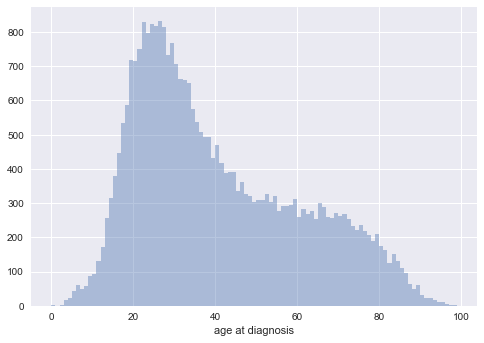

In [6]:
# not age specific 
sns.distplot(
    HPlst['age at diagnosis'],
    kde=False,
    bins=np.arange(0,100,1)
)
plt.savefig(figOutputPath+'HPhist.pdf')

In [7]:
HPlst['age at diagnosis'].describe()

count    30573.000000
mean        40.186210
std         20.033681
min          0.000000
25%         24.000000
50%         35.000000
75%         55.000000
max         99.000000
Name: age at diagnosis, dtype: float64

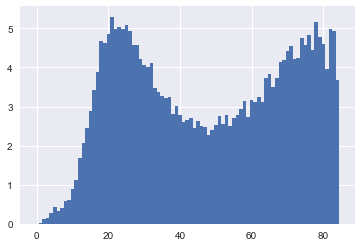

In [9]:
# age specific plot
HPlstbyage=HPlst.groupby(['age at diagnosis (CutOff)']).agg({'population': np.sum})
plt.figure(figsize=(6,4))
plt.bar(left=np.arange(0,85,1),height=HPlstbyage['population']/(2014-1973+1),width=1)
plt.savefig(figOutputPath+'HPagespecific.pdf')

In [10]:
HPlstSurvByAge=HPlst[['age at diagnosis','survival months']]
HPlstSurvByAgeExclude=HPlstSurvByAge[~HPlstSurvByAge['survival months'].isin([9999])]
HPlstSurvByAgegrp=HPlstSurvByAgeExclude.groupby(pd.cut(HPlstSurvByAgeExclude["age at diagnosis"], 
                                                       np.arange(0, 110, 20)))
HPlstSurvByAgegrp.describe()

age at diagnosis                                         \
                            count       mean       std   min   25%   50%   
age at diagnosis                                                           
(0, 20]                    4682.0  15.980564  3.697237   2.0  14.0  17.0   
(20, 40]                  13330.0  29.398350  5.541682  21.0  25.0  29.0   
(40, 60]                   6488.0  49.849260  5.826225  41.0  45.0  50.0   
(60, 80]                   4849.0  69.786348  5.609447  61.0  65.0  69.0   
(80, 100]                  1040.0  85.030769  3.491088  81.0  82.0  84.0   

                             survival months                               \
                   75%   max           count        mean         std  min   
age at diagnosis                                                            
(0, 20]           19.0  20.0          4682.0  203.788765  141.429293  0.0   
(20, 40]          34.0  40.0         13330.0  178.466317  128.096319  0.0   
(40, 60]          55.0  60.0          6488.0  114.144883   99.260742  0.0   
(60, 80]          74.0  80.0          4849.0   57.776655   66.886253  0.0   
(80, 100]         87.0  99.0          1040.0   23.013462   31.772074  0.0   

                                             
                   25%    50%    75%    max  
age at diagnosis                             
(0, 20]           73.0  191.5  318.0  503.0  
(20, 40]          65.0  161.5  279.0  503.0  
(40, 60]          29.0   90.0  177.0  497.0  
(60, 80]           6.0   32.0   88.0  399.0  
(80, 100]          2.0    8.0   34.0  224.0

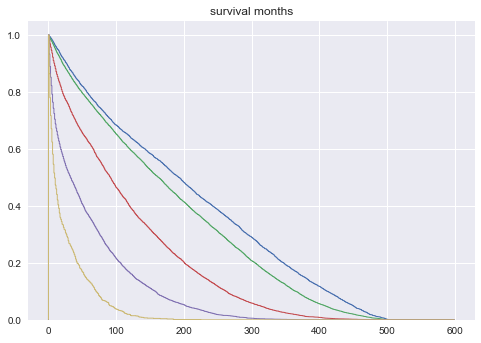

In [19]:
# survival rate age-specific
ax = plt.subplot(1,1,1)
gyn=HPlstSurvByAgegrp.hist(
    column='survival months', 
    bins=np.arange(0,600,1),
    cumulative=-1,
    normed=True,
    histtype='step', 
    ax= ax,
    linewidth = 1
)
plt.savefig(figOutputPath+'HPagespecificByAgegrp.pdf')

age at diagnosis
(0, 20]      [[Axes(0.125,0.125;0.775x0.755)]]
(20, 40]     [[Axes(0.125,0.125;0.775x0.755)]]
(40, 60]     [[Axes(0.125,0.125;0.775x0.755)]]
(60, 80]     [[Axes(0.125,0.125;0.775x0.755)]]
(80, 100]    [[Axes(0.125,0.125;0.775x0.755)]]
dtype: object

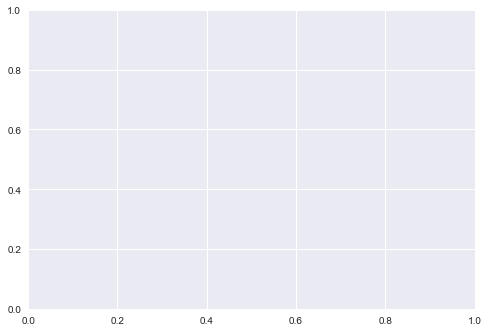

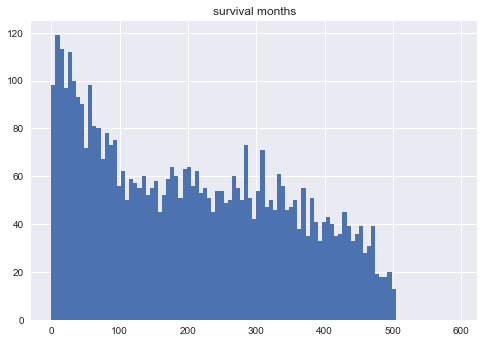

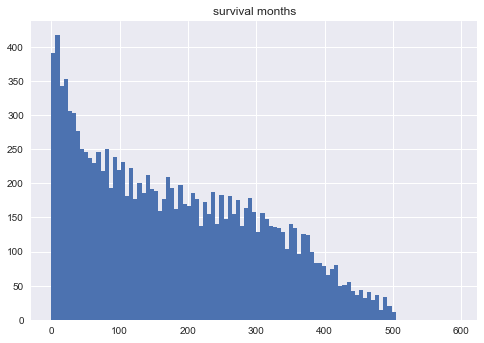

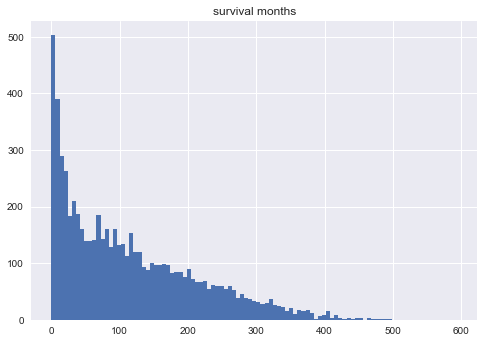

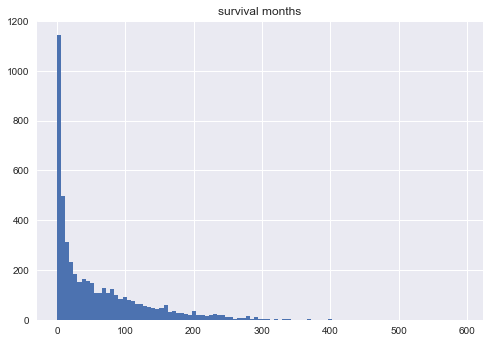

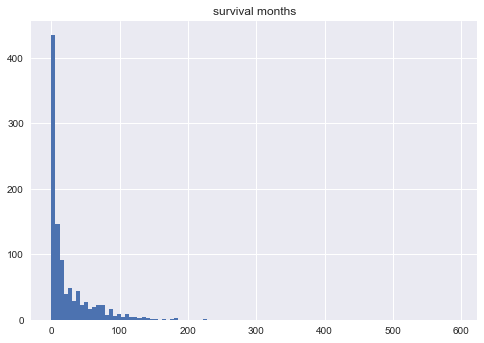

In [20]:
# survival hist in each age group
ax = plt.subplot(1,1,1)
HPlstSurvByAgegrp.hist(column='survival months', bins=np.arange(0,600,6),
                          )
#plt.savefig(figSavePath+'HPagespecificByAgegrpHist.pdf')